In [1]:
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import os

from modules.elbo import ELBO
from modules import optimize_null, forward_simulation

### Load data

In [2]:
# column 1: natural: 1, synthetic: 2
# column 2: A frame
# column 3: B frame
# column 6: What the X frame actually matches (e.g. 1 means it matches A, 2 means it matches B)
# column 7: What the participant reported the X frame matches

subject = 'yb'
category = 'synthetic'
eccentricity = 'periphery'
movie_id = 6
diameter = 6; # 6, 24, 36
dat_movie_name = 'DAM'   # movie name as in the data file name
stim_movie_name = 'carnegie-dam' # movie name as in the stimulus file name

dat = torch.load(Path('data') / 'yoon_data' / f'{subject}_{category}_{eccentricity}_{movie_id:02d}_{dat_movie_name}.pt')
stim_folder = os.path.join('data', 'yoon_stimulus', f'diameter_{diameter:02d}_deg', f'movie{movie_id:02d}-{stim_movie_name}')

In [3]:
# create trial matrices
n_frames = min(max(dat[:, 1]), max(dat[:, 2]))
n_trials = len(dat[:, 0])

n_total_obs = np.zeros((n_frames, n_frames))
n_corr_obs = np.zeros((n_frames, n_frames))

for itrial in range(n_trials):
    a_frame = dat[itrial, 1]
    b_frame = dat[itrial, 2]
    true_frame = a_frame if dat[itrial, 5] == 1 else b_frame
    pred_frame = a_frame if dat[itrial, 6] == 1 else b_frame

    n_total_obs[a_frame-1, b_frame-1] += 1
    n_corr_obs[a_frame-1, b_frame-1] += 1 if true_frame == pred_frame else 0

prob_corr = np.divide(n_corr_obs, n_total_obs, out=np.zeros_like(n_corr_obs), where=n_total_obs!=0)

### Compute null model

In [4]:
is_natural = True if category == 'natural' else False
    
n_dim = n_frames - 1
x_null, c_pixel, c_null, prob_corr_human, prob_corr_null = optimize_null(stim_folder, n_corr_obs, n_total_obs, n_frames-1, n_starts=10, n_iter=10000, n_frames=n_frames, is_natural=is_natural, version=1, disp=False)

Current loss: 240.8344659358263
Loss updated
Iteration 1 | Loss: 240.8344659358263
Current loss: 242.94519804045558
Iteration 2 | Loss: 242.94519804045558
Current loss: 253.56415990367532
Iteration 3 | Loss: 253.56415990367532
Current loss: 258.06510013341904
Iteration 4 | Loss: 258.06510013341904
Current loss: 257.83864722400904
Iteration 5 | Loss: 257.83864722400904
Current loss: 239.80298399552703
Loss updated
Iteration 6 | Loss: 239.80298399552703
Current loss: 240.99770057946444
Iteration 7 | Loss: 240.99770057946444
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 8 | Loss: 237.21303925663233
Current loss: 241.94581035152078
Iteration 9 | Loss: 241.94581035152078
Current loss: 253.3317108824849
Iteration 10 | Loss: 253.3317108824849


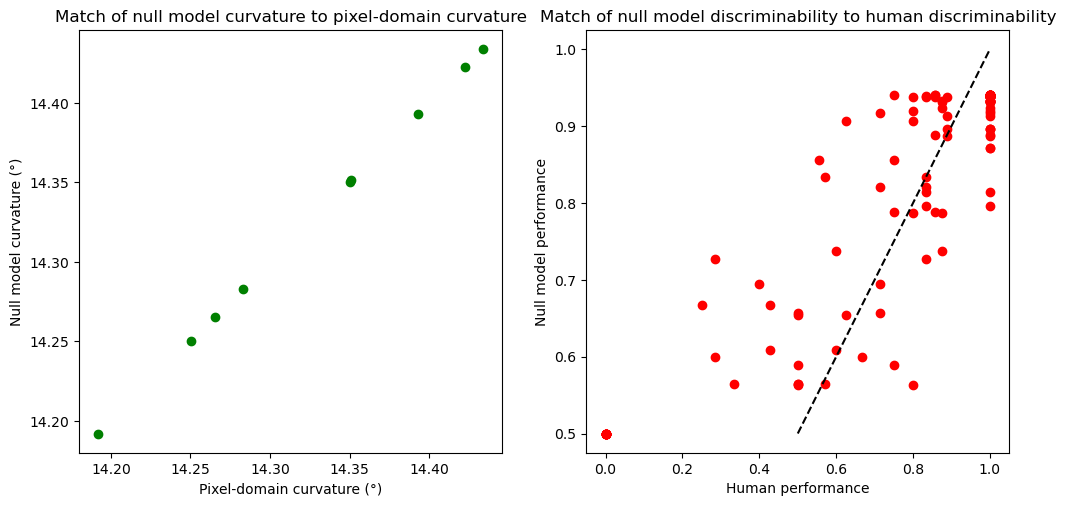

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

axs[0].plot(torch.rad2deg(c_pixel), torch.rad2deg(c_null), 'go')
# axs[0, 0].plot([0.5, 1], [0.5, 1], 'k--')
axs[0].set_title('Match of null model curvature to pixel-domain curvature')
axs[0].set_xlabel('Pixel-domain curvature (°)')
axs[0].set_ylabel('Null model curvature (°)')
axs[0].set_box_aspect(1)

axs[1].plot(prob_corr_human.flatten(), prob_corr_null.flatten().detach(), 'ro')
axs[1].plot([0.5, 1], [0.5, 1], 'k--')
axs[1].set_title('Match of null model discriminability to human discriminability')
axs[1].set_xlabel('Human performance')
axs[1].set_ylabel('Null model performance')
axs[1].set_box_aspect(1)

### Synthesize data from null model observer

In [6]:
# n_reps = int(np.max(n_total_obs))
n_reps = 40
prob_corr_null_sim, n_total_obs_null_sim = forward_simulation(x_null.squeeze(), n_reps)

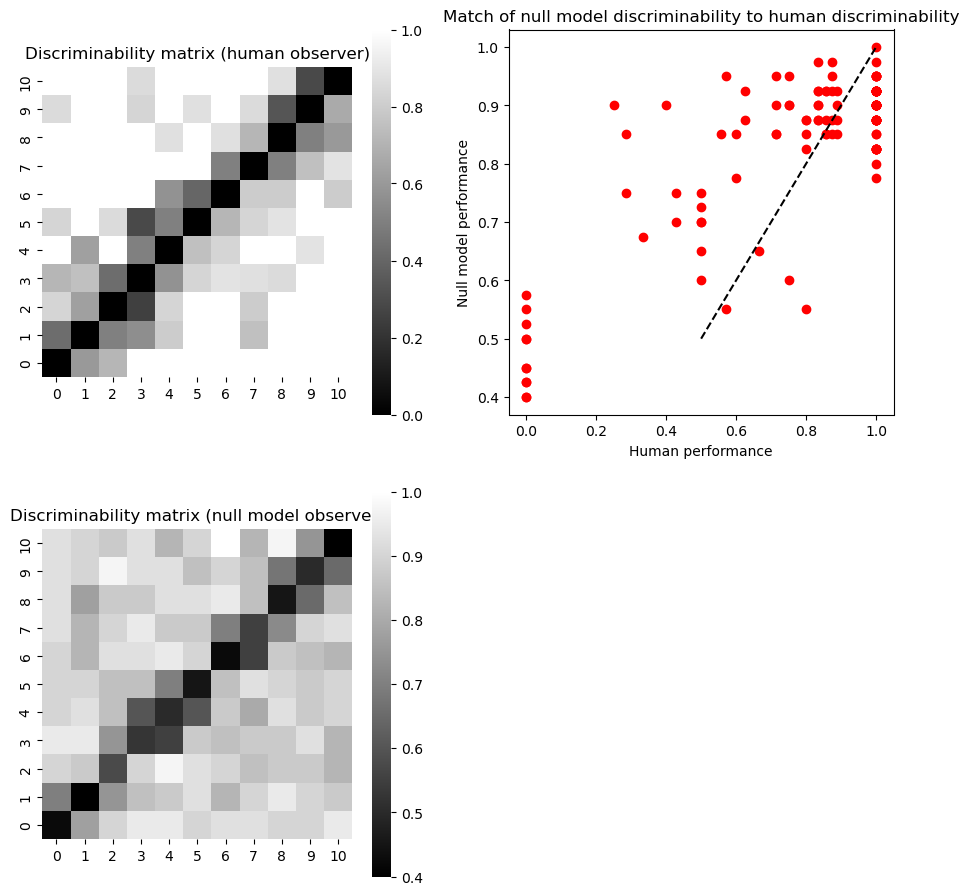

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(11, 11))

sns.heatmap(prob_corr, ax=axs[0, 0], cmap='gray')
axs[0, 0].invert_yaxis()
axs[0, 0].set_title('Discriminability matrix (human observer)')
axs[0, 0].set_box_aspect(1)

sns.heatmap(prob_corr_null_sim, ax=axs[1, 0], cmap='gray')
axs[1, 0].invert_yaxis()
axs[1, 0].set_title('Discriminability matrix (null model observer)')
axs[1, 0].set_box_aspect(1)

axs[0, 1].plot(prob_corr_human.flatten(), prob_corr_null_sim.flatten(), 'ro')
axs[0, 1].plot([0.5, 1], [0.5, 1], 'k--')
axs[0, 1].set_title('Match of null model discriminability to human discriminability')
axs[0, 1].set_xlabel('Human performance')
axs[0, 1].set_ylabel('Null model performance')
axs[0, 1].set_box_aspect(1)

axs[1, 1].set_axis_off()

### Run optimization on real data

In [8]:
elbo = ELBO(n_dim, n_corr_obs, n_total_obs, n_starts=10, n_iterations=80000)
x, p, errors, kl_loss, ll_loss, c_prior, d_prior, l_prior, c_post, d_post, l_post, c_est = elbo.optimize_ELBO_SGD()

Running MLE to initialize posterior..........................
Current loss: 263.3267070353031
Loss updated
Iteration 1 | Loss: 263.3267070353031
Current loss: 249.01437152177095
Loss updated
Iteration 2 | Loss: 249.01437152177095
Current loss: 252.94967433810234
Iteration 3 | Loss: 252.94967433810234
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 4 | Loss: 259.6186056062579
Current loss: 259.38529904931784
Iteration 5 | Loss: 259.38529904931784
Current loss: 255.41724801063538
Iteration 6 | Loss: 255.41724801063538
Current loss: 249.8421777114272
Iteration 7 | Loss: 249.8421777114272
Current loss: 246.51962681114674
Loss updated
Iteration 8 | Loss: 246.51962681114674
Current loss: 262.55034363269806
Iteration 9 | Loss: 262.55034363269806
ABNORMAL_TERMINATION_IN_LNSRCH
Iteration 10 | Loss: 252.17770508676767
Epoch: 0, Loss: 427.23188179153993
Epoch: 250, Loss: 406.3615178639242
Epoch: 500, Loss: 390.1740186796103
Epoch: 750, Loss: 376.56835183038015
Epoch: 1000, Loss: 369.05541854826333
Epoch

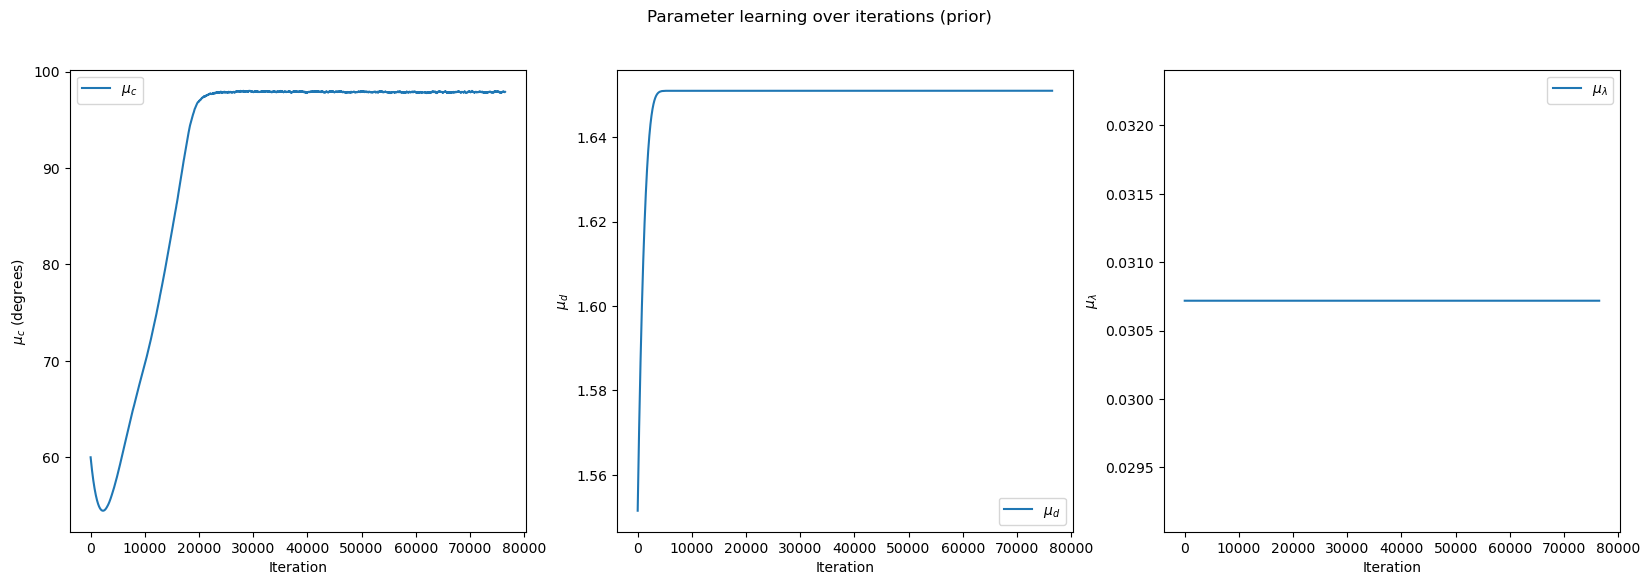

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_prior, label=r'$\mu_c$')
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_prior, label=r'$\mu_d$')
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_prior, label=r'$\mu_{\lambda}$')
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].legend()
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (prior)')
plt.show()

/var/folders/_c/tp58p8fd4t51w6w34tsknzpw0000gr/T/ipykernel_71481/2295650332.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3729.)
  axs[2].plot(l_post.T)


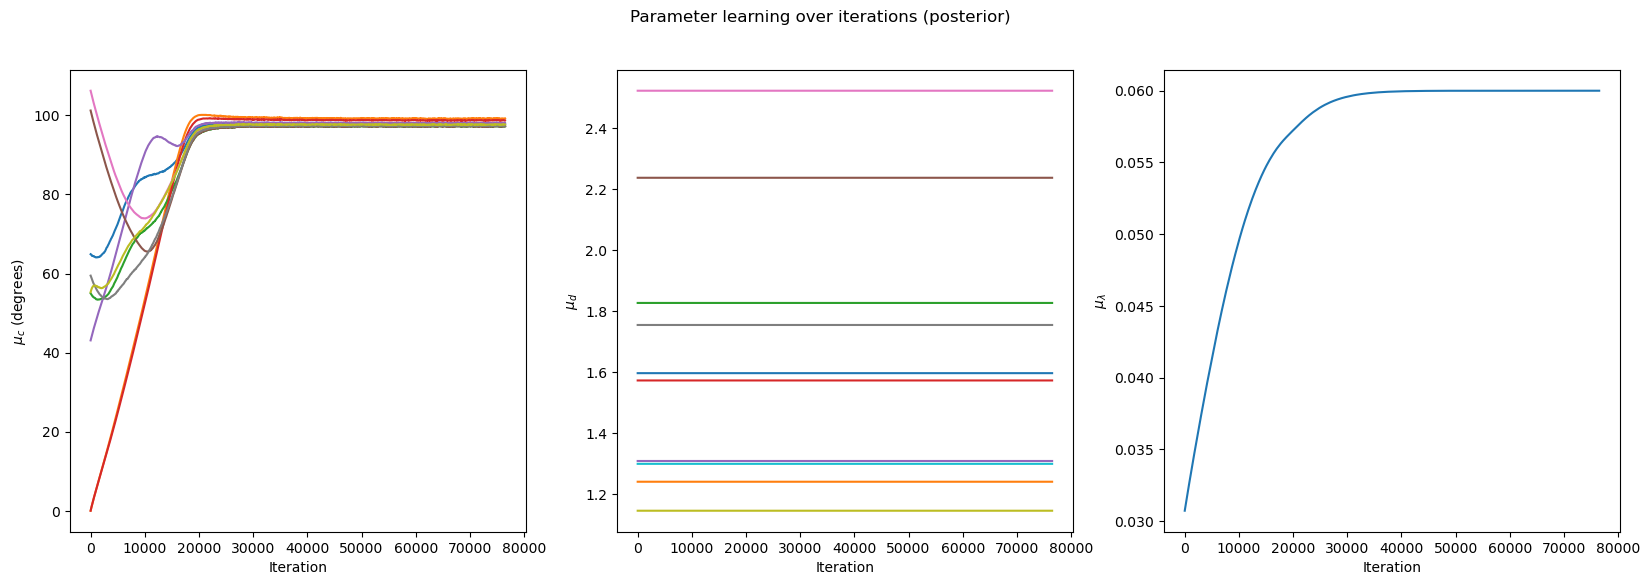

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(c_post.T)
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_post.T)
axs[1].set_ylabel(r'$\mu_{d}$')

axs[2].plot(l_post.T)
axs[2].set_ylabel(r'$\mu_{\lambda}$')

for i in range(3):
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (posterior)')
plt.show()

In [11]:
est_global_curvature = torch.rad2deg(elbo.mu_prior_c.detach())
print(f'Estimated global curvature: {est_global_curvature} degrees')
print(f'Average estimated local curvature: {torch.rad2deg(torch.mean(elbo.mu_post_c).detach())} degrees')

Estimated global curvature: 97.9048843383789 degrees
Average estimated local curvature: 97.90441029135577 degrees


### Run optimization on simulated data from null model

In [14]:
n_corr_obs_null = np.round(n_total_obs_null_sim * prob_corr_null_sim)

elbo_null = ELBO(n_dim, n_corr_obs_null, n_total_obs_null_sim, n_starts=10, n_iterations=80000)
x_null_elbo, p_null_elbo, errors_null_elbo, _, _, _, _, _, _, _, _, _ = elbo_null.optimize_ELBO_SGD()

Running MLE to initialize posterior..........................
Current loss: 1824.4834209010005
Loss updated
Iteration 1 | Loss: 1824.4834209010005
Current loss: 1821.8930583447218
Loss updated
Iteration 2 | Loss: 1821.8930583447218
Current loss: 1683.0954322591424
Loss updated
Iteration 3 | Loss: 1683.0954322591424


KeyboardInterrupt: 

In [13]:
est_global_curvature_null = torch.rad2deg(elbo_null.mu_prior_c.detach())
print(f'Estimated global curvature: {est_global_curvature_null} degrees')
print(f'Average estimated local curvature: {torch.rad2deg(torch.mean(elbo_null.mu_post_c).detach())} degrees')

AttributeError: 'ELBO' object has no attribute 'mu_prior_c'

### Analyze results

In [ ]:
if n_dim > 2:
    # compute PC-reduced perceptual locations
    pca_fit = PCA(n_components=2)

    # ground truth perceptual locations
    pca_fit.fit(x.squeeze().detach())
    pc_fit = pca_fit.components_
else:
    pc_fit = x.squeeze().detach()

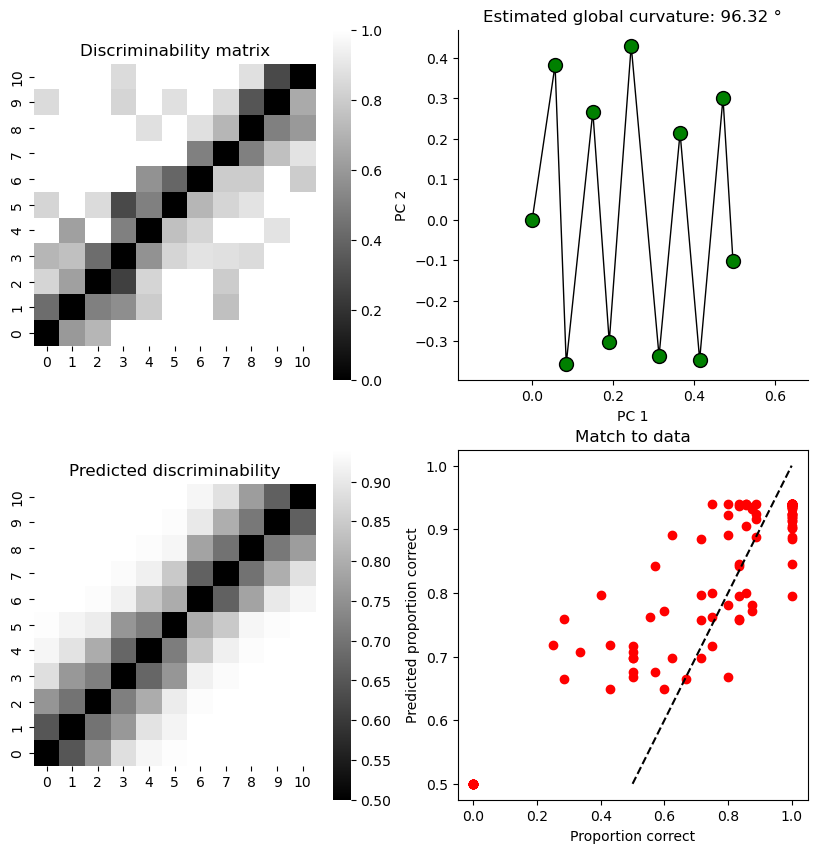

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

sns.heatmap(prob_corr, ax=axs[0, 0], cmap='gray')
axs[0, 0].invert_yaxis()
axs[0, 0].set_title('Discriminability matrix')
axs[0, 0].set_box_aspect(1)

axs[0, 1].plot(pc_fit[0, :], pc_fit[1, :], '-ko', markersize=10, markerfacecolor='g', linewidth=1)
axs[0, 1].set_title(f'Estimated global curvature: {torch.round(torch.rad2deg(torch.mean(elbo.mu_post_c.detach())), decimals=2)} °')
axs[0, 1].set_xlabel('PC 1')
axs[0, 1].set_ylabel('PC 2')
axs[0, 1].set_box_aspect(1)  
axs[0, 1].set_aspect('equal') 
axs[0, 1].spines['top'].set_visible(False)  
axs[0, 1].spines['right'].set_visible(False)
axs[0, 1].set_box_aspect(1)

sns.heatmap(p.detach().squeeze(), ax=axs[1, 0], cmap='gray')
axs[1, 0].invert_yaxis()
axs[1, 0].set_title('Predicted discriminability')
axs[1, 0].set_box_aspect(1)

axs[1, 1].plot(prob_corr.flatten(), p.flatten().detach(), 'ro')
axs[1, 1].plot([0.5, 1], [0.5, 1], 'k--')
axs[1, 1].set_title('Match to data')
axs[1, 1].set_xlabel('Proportion correct')
axs[1, 1].set_ylabel('Predicted proportion correct')
axs[1, 1].set_box_aspect(1)

plt.show()